# Imports

In [1]:
# set up
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import re
import string
# import cvxopt # <- installation via conda recommended
from collections import defaultdict
from sklearn import metrics
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import scipy.optimize as sopt
import scipy.stats as sstats

# Preparing data (IMDb movies' reviews)

## Macro for windows / mac users

In [2]:
#system = 'Mac'
system = 'Win'

In [3]:
train_pos_path = 'data_sets/aclImdb/train/pos/*'
train_neg_path = 'data_sets/aclImdb/train/neg/*'

train_pos = glob.glob(train_pos_path)
train_neg = glob.glob(train_neg_path)


test_pos_path = 'data_sets/aclImdb/test/pos/*'
test_neg_path = 'data_sets/aclImdb/test/neg/*'

test_pos = glob.glob(test_pos_path)
test_neg = glob.glob(test_neg_path)

In [4]:
train_df = []
test_df = []

In [5]:
def read_data(path, message):
    res = []
    for p in tqdm(path, desc=message, position=0):
        with open(p, encoding="utf8") as f:
            text = f.read()

    #         For win users
            if system == 'Win':
                beg, end = p.find('\\'), p.find('.')

    #         For mac users
            if system == 'Mac':
                beg = re.search(r"\d",p).start()-1
                end = p.find('.')

            idx, rating = p[beg+1:-4].split('_')
            res.append([text, rating])
            
    return res

In [6]:
train_df += read_data(path=train_pos, message='Getting positive train data')
train_df += read_data(path=train_neg, message='Getting negative train data')

test_df += read_data(path=test_pos, message='Getting positive test data')
test_df += read_data(path=test_neg, message='Getting negative test data')

Getting negative test data: 100%|███████████████████████████████████████████████| 12500/12500 [00:43<00:00, 290.26it/s]


In [7]:
train_df = pd.DataFrame(train_df, columns=['text', 'rating'])
test_df = pd.DataFrame(test_df, columns=['text', 'rating'])

In [8]:
print('Records: ', train_df.size)
train_df.head()

Records:  50000


,text,rating
0,Bromwell High is a cartoon comedy. It ran at t...,9
1,Homelessness (or Houselessness as George Carli...,8
2,Brilliant over-acting by Lesley Ann Warren. Be...,10
3,This is easily the most underrated film inn th...,7
4,This is not the typical Mel Brooks film. It wa...,8


In [9]:
for i in range(1, 11):
    print(f'Number of reviews with rating {i}: {train_df[train_df.rating == str(i)].shape[0]}')

Number of reviews with rating 1: 5100
Number of reviews with rating 2: 2284
Number of reviews with rating 3: 2420
Number of reviews with rating 4: 2696
Number of reviews with rating 5: 0
Number of reviews with rating 6: 0
Number of reviews with rating 7: 2496
Number of reviews with rating 8: 3009
Number of reviews with rating 9: 2263
Number of reviews with rating 10: 4732


## Clean and Preprocess

In [10]:
def regex(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text

## Remove punctuation

In [11]:
%%time
# Remove punctuaction and lower all texts
train_df.text = train_df.text.apply(lambda row: regex(row))
test_df.text = test_df.text.apply(lambda row: regex(row))

Wall time: 1.59 s


In [12]:
train_df.head()

,text,rating
0,bromwell high is a cartoon comedy it ran at th...,9
1,homelessness or houselessness as george carlin...,8
2,brilliant overacting by lesley ann warren best...,10
3,this is easily the most underrated film inn th...,7
4,this is not the typical mel brooks film it was...,8


In [13]:
# consider only rating 1 and 10
bayes_df_train = train_df[(train_df.rating == '1') | (train_df.rating == '10')]
bayes_df_test = test_df[(test_df.rating == '1') | (test_df.rating == '10')]

## Stemming

In [14]:
stemmer = SnowballStemmer("english")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Febrin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def stem_(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

In [16]:
%%time
stemmed_train_df = bayes_df_train.copy()
stemmed_test_df = bayes_df_test.copy()
stemmed_train_df.text = stemmed_train_df.text.apply(lambda row: stem_(row))
stemmed_test_df.text = stemmed_test_df.text.apply(lambda row: stem_(row))

Wall time: 36.3 s


## Remove stop words

In [17]:
def remove_stop_words(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

In [18]:
%%time
swr_train_df = bayes_df_train.copy()
swr_test_df = bayes_df_test.copy()
swr_train_df.text = swr_train_df.text.apply(lambda row: remove_stop_words(row))
swr_test_df.text = swr_test_df.text.apply(lambda row: remove_stop_words(row))

Wall time: 600 ms


In [19]:
def stem_and_remove_stop_words(text):
    return ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])

In [20]:
%%time
stemmed_swr_train_df = bayes_df_train.copy()
stemmed_swr_test_df = bayes_df_test.copy()
stemmed_swr_train_df.text = stemmed_swr_train_df.text.apply(lambda row: stem_and_remove_stop_words(row))
stemmed_swr_test_df.text = stemmed_swr_test_df.text.apply(lambda row: stem_and_remove_stop_words(row))

Wall time: 24.6 s


## Score visualization

In [21]:
def print_score(preds,Y,name):
    print(name)
    acc = np.mean(preds == Y)
    print(f"Acc: {acc}")
    M = metrics.confusion_matrix(preds,Y)
    N = np.sum(M)
    print('\nConfusion matrix:')
    print(M)
    print(f'\nTrue negative (rating = 1): {M[0][0]}')
    print(f'True positive (rating = 10): {M[1][1]}')
    print(f'False negative: {M[0][1]}')
    print(f'False positive: {M[1][0]}')
    return M,N,acc

# CountVectorizer class

In [22]:
class MyCountVectorizer:
    def __init__(self, min_df=-1, max_df=1e18, binary=False):
        self.min_df = min_df
        self.max_df = max_df
        self.binary = binary
    
    def fit(self, df):
        words_cnt = defaultdict(int)
        col = df.columns[0]
        
        for i in range(len(df)):
            text = df.iloc[i][col]
            for word in text.split():
                words_cnt[word] += 1
                
        all_words = []
        for word, cnt in words_cnt.items():
            if self.min_df <= cnt <= self.max_df:
                all_words.append(word)
                
        self.all_words_ids = {w:i for i,w in enumerate(all_words)}
        self.width = len(all_words)
        
    
    def transform(self, df):
        col = df.columns[0]
        count_matrix = np.zeros([len(df), self.width], \
                                dtype=np.int32)
        
        for i in range(len(df)):
            text = df.iloc[i][col]
            words_cnt = defaultdict(int)
            
            for word in text.split():
                words_cnt[word] += 1
            
            for word, cnt in words_cnt.items():
                if word in self.all_words_ids:
                    pos = self.all_words_ids[word]
                    if self.binary:
                        count_matrix[i][pos] = 1
                    else:
                        count_matrix[i][pos] = cnt
                    
        return count_matrix

# Naive Bayes approach

## Naive Bayes class

In [39]:
class Naive_Bayes:
    def __init__(self,alpha=0,fit_prior=True,class_prior=None):
        self.alpha = alpha
        self.fit_prior = fit_prior
        self.class_prior_array = class_prior
        if class_prior:
            self.fit_prior = False
    
    
    def fit(self,X,y):
        self.classes,prior = np.unique(y,return_counts=True)
        self.N = len(y)
        
        # Setting class prior
        if self.fit_prior:
            self.class_prior = {class_ : np.log(prior[i]/self.N + 1e-100)
                                for i,class_ in enumerate(self.classes)}
        elif self.class_prior_array:
            self.class_prior = {class_ : np.log(self.class_prior_array[i] + 1e-100) 
                                for i,class_ in enumerate(self.classes)}
        else:
            self.class_prior = {class_ : np.log(1/len(self.classes) + 1e-100) 
                                for class_ in self.classes}
            
        # Creating words dictionaries
        self.class_words_counts = {class_ : defaultdict(lambda: 0) 
                                   for class_ in self.classes}
        for i,text in enumerate(X):
            target = y[i]
            for word in text.split():
                self.class_words_counts[target][word] += 1
        
        # Creating probabilities dictionaries
        self.class_words_probs = {class_ : defaultdict(lambda: np.log(self.alpha + 1e-100)) 
                                  for class_ in self.classes}
        for class_,dict_ in self.class_words_counts.items():
            for word,count in dict_.items():
                self.class_words_probs[class_][word] = np.log(count + 1e-100)
    
        self.class_words_amount = {class_ : np.log(sum(self.class_words_counts[class_].values())) 
                                   for class_ in self.classes}
    

    def get_class_log_probabilities(self,text):
        probs = {class_ : 0 for class_ in self.classes}
        for class_ in self.classes:
            for word in text.split():
                probs[class_] += self.class_words_probs[class_][word]
                probs[class_] -= self.class_words_amount[class_]
            probs[class_] += self.class_prior[class_]
        return probs
    
    
    def predict(self,X,return_probabilities = False):
        preds = []
        preds_probs = []
        for text in X:
            prob = self.get_class_log_probabilities(text)
            #prob = {class_ : np.exp(pbb) for class_,pbb in prob.items()}
            preds_probs.append(prob)
            pred = max(prob,key = prob.get)
            preds.append(pred)
        
        if return_probabilities:
            return preds,preds_probs
        return preds


## Train and test accuracy

In [23]:
X_train,y_train = np.array(bayes_df_train['text']),np.array(bayes_df_train['rating'])
X_test,y_test = np.array(bayes_df_test['text']),np.array(bayes_df_test['rating'])

In [24]:
NBc_res = []

In [ ]:
alpha = 1.5
NB = Naive_Bayes(fit_prior = False,alpha=alpha)

In [ ]:
NB.fit(X_train,y_train)

In [ ]:
predictions,ppb = NB.predict(X_train,return_probabilities=True)

In [ ]:
M,N,acc = print_score(predictions,y_train,f"TRAIN, alpha : {alpha}")
NBc_res.append(['Org train data\na=1.5','Acc',acc])
NBc_res.append(['Org train data\na=1.5','FN',M[0][1]/N])
NBc_res.append(['Org train data\na=1.5','FP',M[1][0]/N])

In [ ]:
predictions,ppb = NB.predict(X_test,return_probabilities=True)

In [ ]:
M,N,acc = print_score(predictions,y_test,f"TEST, alpha : {alpha}")
NBc_res.append(['Org test data\na=1.5','Acc',acc])
NBc_res.append(['Org test data\na=1.5','FN',M[0][1]/N])
NBc_res.append(['Org test data\na=1.5','FP',M[1][0]/N])

Now we can try use alpha = 0

In [ ]:
alpha = 0.0
NB = Naive_Bayes(fit_prior = False,alpha=alpha)

In [ ]:
NB.fit(X_train,y_train)

In [ ]:
predictions,ppb = NB.predict(X_train,return_probabilities=True)

In [ ]:
M,N,acc = print_score(predictions,y_train,f"TRAIN, alpha : {alpha}")

In [ ]:
predictions,ppb = NB.predict(X_test,return_probabilities=True)

In [ ]:
M,N,acc = print_score(predictions,y_test,f"TEST, alpha : {alpha}")

Setting alpha to 0 improve our train accuracy, but decrease train accuracy, so it`s overfitting. 
We can try to find best alpha for our data.

## Testing different alphas

In [ ]:
for alpha in [0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,3.0,4.0,5.0,10.0]:
    NB = Naive_Bayes(fit_prior = False,alpha=alpha)
    NB.fit(X_train,y_train)
    predictions,ppb = NB.predict(X_test,return_probabilities=True)
    acc = np.mean(predictions == y_test)
    print(f'Alpha : {alpha}, test acc: {acc}')

## Stemming and stop words removing

In [ ]:
alpha = 1.5

In [ ]:
NB = Naive_Bayes(fit_prior = False,alpha=alpha)
NB.fit(np.array(stemmed_train_df['text']),np.array(stemmed_train_df['rating']))
predictions = NB.predict(np.array(stemmed_test_df['text']))
M,N,acc = print_score(predictions,np.array(stemmed_test_df['rating']),
                      f"TEST, alpha : {alpha}, stemmed")
NBc_res.append(['Stemmed test data\na=1.5','Acc',acc])
NBc_res.append(['Stemmed test data\na=1.5','FN',M[0][1]/N])
NBc_res.append(['Stemmed test data\na=1.5','FP',M[1][0]/N])

In [ ]:
NB = Naive_Bayes(fit_prior = False,alpha=alpha)
NB.fit(np.array(swr_train_df['text']),np.array(swr_test_df['rating']))
predictions = NB.predict(np.array(swr_test_df['text']))
M,N,acc = print_score(predictions,np.array(stemmed_test_df['rating']),
                      f"TEST, alpha : {alpha}, stop words removed")
NBc_res.append(['Test data\nwithout stopwords\na=1.5','Acc',acc])
NBc_res.append(['Test data\nwithout stopwords\na=1.5','FN',M[0][1]/N])
NBc_res.append(['Test data\nwithout stopwords\na=1.5','FP',M[1][0]/N])

In [ ]:
NB = Naive_Bayes(fit_prior = False,alpha=alpha)
NB.fit(np.array(stemmed_swr_train_df['text']),np.array(stemmed_swr_train_df['rating']))
predictions = NB.predict(np.array(stemmed_swr_test_df['text']))
M,N,acc = print_score(predictions,np.array(stemmed_test_df['rating']),
                      f"TEST, alpha : {alpha}, stemmed and stop words removed")
NBc_res.append(['Stemmed test data\nwithout stop words\na=1.5','Acc',acc])
NBc_res.append(['Stemmed test data\nwithout stop words\na=1.5','FN',M[0][1]/N])
NBc_res.append(['Stemmed test data\nwithout stop words\na=1.5','FP',M[1][0]/N])

In [ ]:
NBc_res_df = pd.DataFrame(NBc_res,columns = ['Data','Y','Value'])

In [ ]:
sns.catplot(x="Data", y="Value", hue="Y", data=NBc_res_df,
                height=5, aspect = 2, kind="bar", palette="muted")
plt.title("Our Naive Bayes class")

## Sklearn Naive Bayes

In [ ]:
NBb_res = []

In [ ]:
CV_NB = CountVectorizer()
X_train,y_train = np.array(bayes_df_train['text']),np.array(bayes_df_train['rating'])
X_test,y_test = np.array(bayes_df_test['text']),np.array(bayes_df_test['rating'])
X_train_cv = CV_NB.fit_transform(X_train)
X_test_cv = CV_NB.transform(X_test)

In [ ]:
alpha = 1.5
MNB = MultinomialNB(alpha = 1.5)
MNB.fit(X_train_cv,y_train)
predictions = MNB.predict(X_train_cv)
M,N,acc = print_score(predictions,y_train,f"TRAIN, alpha : {alpha}")
NBb_res.append(['Org train data\na=1.5','Acc',acc])
NBb_res.append(['Org train data\na=1.5','FN',M[0][1]/N])
NBb_res.append(['Org train data\na=1.5','FP',M[1][0]/N])

In [ ]:
alpha = 1.5
MNB = MultinomialNB(alpha = 1.5)
MNB.fit(X_train_cv,y_train)
predictions = MNB.predict(X_test_cv)
M,N,acc = print_score(predictions,y_test,f"TEST, alpha : {alpha}")
NBb_res.append(['Org test data\na=1.5','Acc',acc])
NBb_res.append(['Org test data\na=1.5','FN',M[0][1]/N])
NBb_res.append(['Org test data\na=1.5','FP',M[1][0]/N])

In [ ]:
CV_NB = CountVectorizer()
X_train,y_train = np.array(stemmed_train_df['text']),np.array(stemmed_train_df['rating'])
X_test,y_test = np.array(stemmed_test_df['text']),np.array(stemmed_test_df['rating'])
X_train_cv = CV_NB.fit_transform(X_train)
X_test_cv = CV_NB.transform(X_test)

In [ ]:
alpha = 1.5
MNB = MultinomialNB(alpha = 1.5)
MNB.fit(X_train_cv,y_train)
predictions = MNB.predict(X_test_cv)
M,N,acc = print_score(predictions,y_test,
                      f"TEST, alpha : {alpha}, stemmed")
NBb_res.append(['Stemmed test data\na=1.5','Acc',acc])
NBb_res.append(['Stemmed test data\na=1.5','FN',M[0][1]/N])
NBb_res.append(['Stemmed test data\na=1.5','FP',M[1][0]/N])

In [ ]:
CV_NB = CountVectorizer()
X_train,y_train = np.array(swr_train_df['text']),np.array(swr_train_df['rating'])
X_test,y_test = np.array(swr_test_df['text']),np.array(swr_test_df['rating'])
X_train_cv = CV_NB.fit_transform(X_train)
X_test_cv = CV_NB.transform(X_test)

In [ ]:
alpha = 1.5
MNB = MultinomialNB(alpha = 1.5)
MNB.fit(X_train_cv,y_train)
predictions = MNB.predict(X_test_cv)
M,N,acc = print_score(predictions,y_test,
                      f"TEST, alpha : {alpha}, stemmed")
NBb_res.append(['Test data\nwithout stopwords\na=1.5','Acc',acc])
NBb_res.append(['Test data\nwithout stopwords\na=1.5','FN',M[0][1]/N])
NBb_res.append(['Test data\nwithout stopwords\na=1.5','FP',M[1][0]/N])

In [ ]:
CV_NB = CountVectorizer()
X_train,y_train = np.array(stemmed_swr_train_df['text']),np.array(stemmed_swr_train_df['rating'])
X_test,y_test = np.array(stemmed_swr_test_df['text']),np.array(stemmed_swr_test_df['rating'])
X_train_cv = CV_NB.fit_transform(X_train)
X_test_cv = CV_NB.transform(X_test)

In [ ]:
alpha = 1.5
MNB = MultinomialNB(alpha = 1.5)
MNB.fit(X_train_cv,y_train)
predictions = MNB.predict(X_test_cv)
M,N,acc = print_score(predictions,y_test,
                      f"TEST, alpha : {alpha}, stemmed")
NBb_res.append(['Stemmed test data\nwithout stop words\na=1.5','Acc',acc])
NBb_res.append(['Stemmed test data\nwithout stop words\na=1.5','FN',M[0][1]/N])
NBb_res.append(['Stemmed test data\nwithout stop words\na=1.5','FP',M[1][0]/N])

In [ ]:
NBb_res_df = pd.DataFrame(NBb_res,columns = ['Data','Y','Value'])

In [ ]:
sns.catplot(x="Data", y="Value", hue="Y", data=NBb_res_df,
                height=5, aspect = 2, kind="bar", palette="muted")
plt.title("Sklearn MultinomialNaiveBayes")

## Compare our NB with sklearn`s

In [ ]:
NBc_res_df_copyed = NBc_res_df.copy()
A_df = NBc_res_df[NBc_res_df.Y == 'Acc']
A_df.Y = ['Our'] * 5

In [ ]:
NBb_res_df_copyed = NBb_res_df.copy()
B_df = NBb_res_df[NBb_res_df.Y == 'Acc']
B_df.Y = ['Sklearn'] * 5

In [ ]:
compare_df = pd.concat([A_df,B_df])

In [ ]:
sns.catplot(x="Data", y="Value", hue="Y", data=compare_df,
                height=5, aspect = 2, kind="bar", palette="muted")
plt.ylim(0.9,1.0)
plt.title("Our Naive Bayes class vs Sklearn MultinomialNaiveBayes")

# Logistic Regression

## Logistic Regression class

In [25]:
class Logistic_Regression:
    def __init__(self, max_iter=500, solver_calls=5,lambda_ = 0.1,Theta=None, solver=sopt.fmin_l_bfgs_b, debug=False):
        self.Theta = Theta
        self.solver_calls = solver_calls
        self.max_iter = max_iter
        self.solver = solver
        self.debug = debug
        self.lambda_ = lambda_
    
    def __sigmoid(self,x):
        return 1 / (1 + np.exp(-x))    
    
    def __logreg_loss(self, Theta, X, Y):
        Theta = Theta.astype(np.float64)
        X = X.astype(np.float64)
        Y = Y.astype(np.float64)
        
        if self.debug:
            print(f"Loss calculating... ",end="")
        Z = np.dot(Theta,X.T)
        if self.debug:
            print(f" Z done... ",end="")
        SZ = self.__sigmoid(Z)
        Y_ = Y[:,np.newaxis]
        nll = -np.sum((Y_*np.log2(SZ+1e-50) + (1-Y_)*np.log2(1-SZ+1e-50)))
#         nll = -np.mean([
#                         y * np.log2(SZ + 1e-10) \
#                         + (1-y) * np.log2(1 - SZ + 1e-10) \
#                         for y in Y
#                         ])
        nll += (self.lambda_/2) * np.sum(Theta**2)
        if self.debug:
            print(f" nll done... ",end="")
        grad = np.dot(X.T, (SZ - Y).T ) / len(Y)
        grad = grad.reshape(Theta.shape) + self.lambda_ * Theta
        if self.debug:
            print(f" grad done... done ")
        return nll, grad
    
    def fit(self,X,y):
        Theta = self.Theta
        if Theta is None:
            Theta = np.ones(X.shape[1]+1)
        
        X_with_ones = np.hstack((np.ones((X.shape[0],1)),X))
      
        for i in tqdm(range(self.solver_calls), desc='Calculating Theta', position=0):
            Theta = self.solver(lambda th: self.__logreg_loss(th, X_with_ones, y), 
                                Theta, maxiter=self.max_iter)[0]
        self.Theta = Theta
    
#     def __logreg_classify(self, X):
#         return (self.Theta.T.dot(X) >= 0)

#     def predict(self, Xs):
#         return [self.__logreg_classify(x) for x in Xs]
    
    def predict(self,X):
        X_with_ones = np.hstack((np.ones((X.shape[0],1)),X))
        preds = (np.dot(self.Theta,X_with_ones.T) >= 0) * 1
        return preds
        

## Train and test accuracy

In [26]:
LGc_res = []

y_train = np.array(list(map(int, bayes_df_train['rating']))) // 10
y_test = np.array(list(map(int, bayes_df_test['rating']))) // 10

In [27]:
%%time
cv = MyCountVectorizer(min_df=5)
cv.fit(bayes_df_train)

X_train = cv.transform(bayes_df_train) 
X_test = cv.transform(bayes_df_test)

Wall time: 5.41 s


In [36]:
Theta_beg = pd.read_csv('Theta_opt_rawtext.csv')['Theta']

In [29]:
LR = Logistic_Regression(max_iter=500, solver_calls=20, lambda_=0.1, Theta=None, debug=False)

In [30]:
%%time
LR.fit(X_train, y_train)

Calculating Theta:   0%|                                                                        | 0/20 [00:00<?, ?it/s]C:\Users\Febrin\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
Calculating Theta: 100%|███████████████████████████████████████████████████████████████| 20/20 [15:04<00:00, 45.21s/it]


Wall time: 15min 4s


In [31]:
pd.DataFrame(LR.Theta, columns=['Theta']).to_csv('Theta_opt_rawtext.csv')

In [32]:
predictions = LR.predict(X_train)

In [33]:
M, N, acc = print_score(predictions, y_train, 'TRAIN')
LGc_res.append(['Org train data\n','Acc',acc])
LGc_res.append(['Org train data\n','FN',M[0][1]/N])
LGc_res.append(['Org train data\n','FP',M[1][0]/N])

TRAIN
Acc: 0.8819161920260374

Confusion matrix:
[[4532  593]
 [ 568 4139]]

True negative (rating = 1): 4532
True positive (rating = 10): 4139
False negative: 593
False positive: 568


In [34]:
predictions = LR.predict(X_test)

In [35]:
M, N, acc = print_score(predictions, y_test, 'TEST')
LGc_res.append(['Org test data\n','Acc',acc])
LGc_res.append(['Org test data\n','FN',M[0][1]/N])
LGc_res.append(['Org test data\n','FP',M[1][0]/N])

TEST
Acc: 0.8678774573395869

Confusion matrix:
[[4393  695]
 [ 629 4304]]

True negative (rating = 1): 4393
True positive (rating = 10): 4304
False negative: 695
False positive: 629


## Stemming and stop words removal

In [38]:
%%time
cv = MyCountVectorizer(min_df=5)
cv.fit(stemmed_swr_train_df)

X_train = cv.transform(stemmed_swr_train_df) 
X_test = cv.transform(stemmed_swr_test_df)

Wall time: 4.4 s


In [39]:
Theta_beg = pd.read_csv('Theta_opt_stem_stop.csv')['Theta']

In [40]:
LR = Logistic_Regression(max_iter=500, solver_calls=20,lambda_=0.1, Theta=None, debug=False)

In [41]:
%%time
LR.fit(X_train, y_train)

Calculating Theta:   0%|                                                                        | 0/20 [00:00<?, ?it/s]C:\Users\Febrin\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
Calculating Theta: 100%|███████████████████████████████████████████████████████████████| 20/20 [13:16<00:00, 39.82s/it]


Wall time: 13min 16s


In [42]:
pd.DataFrame(LR.Theta, columns=['Theta']).to_csv('Theta_opt_stem_stop.csv')

In [43]:
predictions = LR.predict(X_train)

In [44]:
M, N, acc = print_score(predictions, y_train, 'STEMMED TRAIN WITHOUT STOP WORDS')
LGc_res.append(['Stemmed train data\nwithout stop words\n','Acc',acc])
LGc_res.append(['Stemmed train data\nwithout stop words\n','FN',M[0][1]/N])
LGc_res.append(['Stemmed train data\nwithout stop words\n','FP',M[1][0]/N])

STEMMED TRAIN WITHOUT STOP WORDS
Acc: 0.9083604556550041

Confusion matrix:
[[4639  440]
 [ 461 4292]]

True negative (rating = 1): 4639
True positive (rating = 10): 4292
False negative: 440
False positive: 461


In [45]:
predictions = LR.predict(X_test)

In [46]:
M, N, acc = print_score(predictions, y_test, 'STEMMED TEST WITHOUT STOP WORDS')
LGc_res.append(['Stemmed test data\nwithout stop words\n','Acc',acc])
LGc_res.append(['Stemmed test data\nwithout stop words\n','FN',M[0][1]/N])
LGc_res.append(['Stemmed test data\nwithout stop words\n','FP',M[1][0]/N])

STEMMED TEST WITHOUT STOP WORDS
Acc: 0.8992116555234009

Confusion matrix:
[[4528  516]
 [ 494 4483]]

True negative (rating = 1): 4528
True positive (rating = 10): 4483
False negative: 516
False positive: 494


In [47]:
LGc_res_df = pd.DataFrame(LGc_res,columns=['Data','Y','Value'])

Text(0.5, 1, 'Our Linear Regression class')

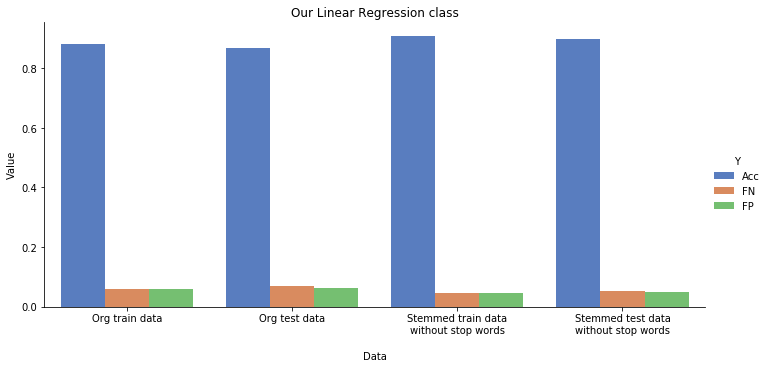

In [48]:
sns.catplot(x="Data", y="Value", hue="Y", data=LGc_res_df,
                height=5, aspect = 2, kind="bar", palette="muted")
plt.title("Our Linear Regression class")

## Sklearn Linear Regression

In [49]:
%%time
cv = CountVectorizer(min_df=5)
cv.fit(stemmed_swr_train_df.text)
cv2 = CountVectorizer(min_df=5)
cv2.fit(bayes_df_train.text)

X_train_og = cv2.transform(bayes_df_train.text)
X_test_og = cv2.transform(bayes_df_test.text)

X_train_stem_swr = cv.transform(stemmed_swr_train_df.text)
X_test_stem_swr = cv.transform(stemmed_swr_test_df.text)

y_train = np.array(list(map(int, bayes_df_train['rating']))) // 10
y_test = np.array(list(map(int, bayes_df_test['rating']))) // 10

LG2_res = []

Wall time: 6.55 s


In [50]:
%%time
for c in [0.01, 0.05, 0.25, 0.5, 1, 5]:    
    lr = LogisticRegression(C=c, max_iter=500, solver='lbfgs') 
    lr.fit(X_train_og, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, lr.predict(X_test_og))))

Accuracy for C=0.01: 0.9154774972557629
Accuracy for C=0.05: 0.9246582177427403
Accuracy for C=0.25: 0.9228619898213751
Accuracy for C=0.5: 0.92106576190001
Accuracy for C=1: 0.9190699530984932
Accuracy for C=5: 0.9140804310947012
Wall time: 11.1 s


In [51]:
best_C = 0.05
best_lr = LogisticRegression(C=best_C, max_iter=500, solver='lbfgs') 
best_lr.fit(X_train_og, y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
M, N, acc = print_score(best_lr.predict(X_train_og), y_train, 'TRAIN')
LG2_res.append(['Org train data\n','Acc',acc])
LG2_res.append(['Org train data\n','FN',M[0][1]/N])
LG2_res.append(['Org train data\n','FP',M[1][0]/N])

TRAIN
Acc: 0.9790480065093572

Confusion matrix:
[[4993   99]
 [ 107 4633]]

True negative (rating = 1): 4993
True positive (rating = 10): 4633
False negative: 99
False positive: 107


In [53]:
M, N, acc = print_score(best_lr.predict(X_test_og), y_test, 'TEST')
LG2_res.append(['Org test data\n','Acc',acc])
LG2_res.append(['Org test data\n','FN',M[0][1]/N])
LG2_res.append(['Org test data\n','FP',M[1][0]/N])

TEST
Acc: 0.9246582177427403

Confusion matrix:
[[4618  351]
 [ 404 4648]]

True negative (rating = 1): 4618
True positive (rating = 10): 4648
False negative: 351
False positive: 404


In [54]:
# stemmed data without stop words
best_C = 0.05
lrs = LogisticRegression(C=best_C, max_iter=500, solver='lbfgs') 
lrs.fit(X_train_stem_swr, y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
M, N, acc = print_score(lrs.predict(X_train_stem_swr), y_train, 'STEMMED TRAIN WITHOUT STOP WORDS')
LG2_res.append(['Stemmed train data\nwithout stop words\n','Acc',acc])
LG2_res.append(['Stemmed train data\nwithout stop words\n','FN',M[0][1]/N])
LG2_res.append(['Stemmed train data\nwithout stop words\n','FP',M[1][0]/N])

STEMMED TRAIN WITHOUT STOP WORDS
Acc: 0.9736574450772986

Confusion matrix:
[[4952  111]
 [ 148 4621]]

True negative (rating = 1): 4952
True positive (rating = 10): 4621
False negative: 111
False positive: 148


In [56]:
M, N, acc = print_score(lrs.predict(X_test_stem_swr), y_test, 'STEMMED TEST WITHOUT STOP WORDS')
LG2_res.append(['Stemmed test data\nwithout stop words\n','Acc',acc])
LG2_res.append(['Stemmed test data\nwithout stop words\n','FN',M[0][1]/N])
LG2_res.append(['Stemmed test data\nwithout stop words\n','FP',M[1][0]/N])

STEMMED TEST WITHOUT STOP WORDS
Acc: 0.9215647141003892

Confusion matrix:
[[4584  348]
 [ 438 4651]]

True negative (rating = 1): 4584
True positive (rating = 10): 4651
False negative: 348
False positive: 438


In [57]:
LG2_res_df  = pd.DataFrame(LG2_res, columns = ['Data','Y','Value'])

Text(0.5, 1, 'Sklearn Linear Regression')

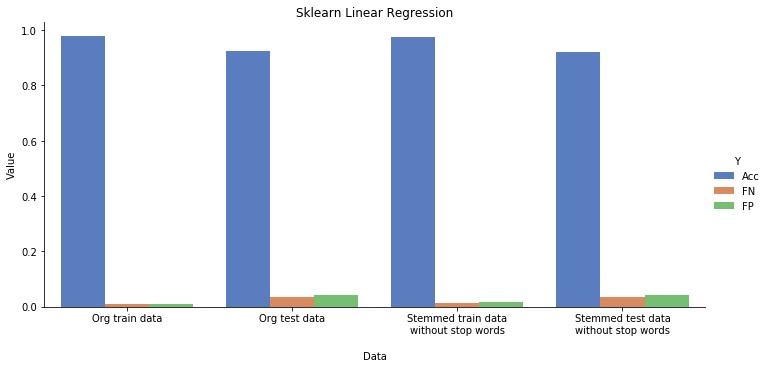

In [58]:
sns.catplot(x="Data", y="Value", hue="Y", data=LG2_res_df,
                height=5, aspect = 2, kind="bar", palette="muted")
plt.title("Sklearn Linear Regression")

## Compare our LR with sklearn's

In [59]:
A_df = LGc_res_df[LGc_res_df.Y == 'Acc']
A_df.Y = ['Our'] * 4

B_df = LG2_res_df[LG2_res_df.Y == 'Acc']
B_df.Y = ['Sklearn'] * 4

C:\Users\Febrin\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Text(0.5, 1, 'Our Naive Bayes class vs Sklearn MultinomialNaiveBayes')

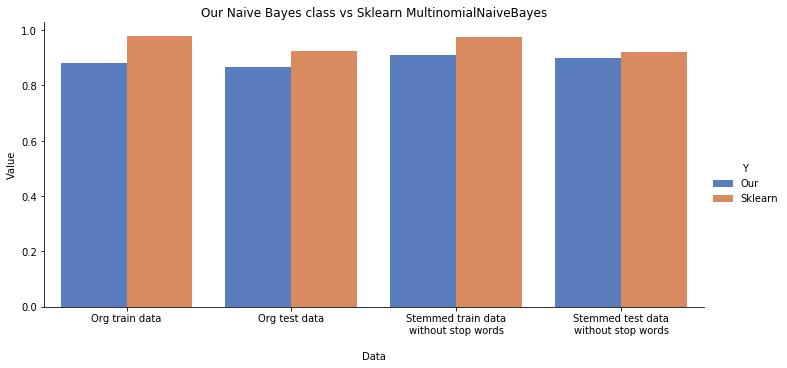

In [60]:
compare_df = pd.concat([A_df,B_df])

sns.catplot(x="Data", y="Value", hue="Y", data=compare_df,
                height=5, aspect = 2, kind="bar", palette="muted")
plt.title("Our Naive Bayes class vs Sklearn MultinomialNaiveBayes")

# SVM

## SVM class

In [ ]:
class SVM:
    def __init__(self,C,gamma,th=1e-5):
        self.C = C
        self.gamma = gamma
        self.th = th
    def fit(self,X,y,info=False):
        m,n = X.shape
        
        # kernel matrix
        if info:
            print(f'Calculating kernel matrix...',end='')
        K = rbf_kernel(X,X,gamma=self.gamma)
        
        # setup solver
        if info:
            print(f'Setting solver...',end='')
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(-np.ones((m, 1)))
        G = cvxopt.matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
        h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
        A = cvxopt.matrix(y.reshape(1, -1))
        b = cvxopt.matrix(np.zeros(1))
        if info:
            print(f'starting solver...')
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol['x'])
        
        # getting support vectors
        self.S = (self.alphas > self.th).reshape(-1, )
        self.support_vextors = X[self.S]
        self.sv_target = y[self.S]
        
        # getting bias
        if info:
            print(f'Calculating bias...',end='')
        K_sv = rbf_kernel(self.support_vextors,self.support_vextors,gamma=self.gamma)
        B = self.sv_target.ravel() - np.sum(K_sv * self.sv_target.ravel() * self.alphas[self.S].ravel(),axis=1)
        self.bias = sstats.mode(B)[0][0]
        
        if info:
            print(f'done')
        
    def predict(self,X):
        K = rbf_kernel(X,self.support_vextors,gamma=self.gamma)
        preds = np.sign(np.sum(K * self.sv_target.ravel() * self.alphas[self.S].ravel(),axis=1) + self.bias)
        return preds

## Train and test accuracy

In [ ]:
CV = MyCountVectorizer(min_df = 5)

In [ ]:
CV.fit(stemmed_swr_train_df)

In [ ]:
X_train_SVM,X_test_SVM = CV.transform(stemmed_swr_train_df),CV.transform(stemmed_swr_test_df)

In [ ]:
y_train = np.array([-1.0 if r == '1' else 1.0 for r in stemmed_swr_train_df['rating']]).reshape(-1,1)

In [ ]:
y_test = np.array([-1.0 if r == '1' else 1.0 for r in stemmed_swr_test_df['rating']]).reshape(-1,1)

In [ ]:
C = 1.25
gamma = 0.0025

In [ ]:
svm_model = SVM(C,gamma)

In [ ]:
svm_model.fit(X_train_SVM,y_train,info=True)

In [ ]:
svm_predictions_train = svm_model.predict(X_train_SVM)

In [ ]:
M,N,acc = print_score(svm_predictions_train,y_train.ravel(),
                      f'Train data, SVM, rbf kernel, C={C}, gamma={gamma}')

In [ ]:
svm_predictions = svm_model.predict(X_test_SVM)

In [ ]:
M,N,acc = print_score(svm_predictions,y_test.ravel(),
                      f'Test data, SVM, rbf kernel, C={C}, gamma={gamma}')

## Testing different parameters

In [ ]:
SVMc_res_train = []
SVMc_res_test = []

In [ ]:
for c in [1.0,1.25,1.5]:
    for gamma_ in [0.001,0.0025,0.005]:
        svm_test_model = SVM(c,gamma_)
        print(f'C: {c}, gamma: {gamma_}')
        svm_test_model.fit(X_train_SVM,y_train,info=False)
        svm_preds_train = svm_test_model.predict(X_train_SVM)
        svm_preds_test = svm_test_model.predict(X_test_SVM)
        M_train,N_train,acc_train = print_score(svm_preds_train,y_train.ravel(),
                      f'Train data, SVM, rbf kernel, C={c}, gamma={gamma_}')
        M_test,N_test,acc_test = print_score(svm_preds_test,y_test.ravel(),
                      f'Test data, SVM, rbf kernel, C={c}, gamma={gamma_}')
        SVMc_res_train.append([f'C = {c}\ngamma = {gamma_}','Acc',acc_train])
        SVMc_res_train.append([f'C = {c}\ngamma = {gamma_}','FN',M_train[0][1]/N_train])
        SVMc_res_train.append([f'C = {c}\ngamma = {gamma_}','FP',M_train[1][0]/N_train])
        SVMc_res_test.append([f'C = {c}\ngamma = {gamma_}','Acc',acc_test])
        SVMc_res_test.append([f'C = {c}\ngamma = {gamma_}','FN',M_test[0][1]/N_test])
        SVMc_res_test.append([f'C = {c}\ngamma = {gamma_}','FP',M_test[1][0]/N_test])
        print()

In [ ]:
SVMc_res_train_df = pd.DataFrame(SVMc_res_train,columns = ['Data','Y','Value'])
SVMc_res_test_df = pd.DataFrame(SVMc_res_test,columns = ['Data','Y','Value'])

In [ ]:
sns.catplot(x="Data", y="Value", hue="Y", data=SVMc_res_train_df,
                height=5, aspect = 3, kind="bar", palette="muted")
plt.title("Stemmed train data without stop words, SVM with rbf kernel")

In [ ]:
sns.catplot(x="Data", y="Value", hue="Y", data=SVMc_res_test_df,
                height=5, aspect = 3, kind="bar", palette="muted")
plt.title("Stemmed test data without stop words, SVM with rbf kernel")

In [ ]:
SVMc_res_train_df_copyed = SVMc_res_train_df.copy()
SVM_A_df = SVMc_res_train_df_copyed[SVMc_res_train_df_copyed.Y == 'Acc']
SVM_A_df.Y = ['Train'] * 9
SVMc_res_test_df_copyed = SVMc_res_test_df.copy()
SVM_B_df = SVMc_res_test_df_copyed[SVMc_res_test_df_copyed.Y == 'Acc']
SVM_B_df.Y = ['Test'] * 9
compare_svm_df = pd.concat([SVM_A_df,SVM_B_df])

In [ ]:
sns.catplot(x="Data", y="Value", hue="Y", data=compare_svm_df,
                height=5, aspect = 3, kind="bar", palette="muted")
plt.title("Stemmed test data without stop words, SVM with rbf kernel, Train vs test accuracy")
plt.ylim(0.9,1.0)

## Sklearn SVM

In [ ]:
CV = CountVectorizer(min_df=5)

In [ ]:
CV.fit(stemmed_swr_train_df['text'])

In [12]:
X_train_SVM = CV.transform(stemmed_swr_train_df['text'])
X_test_SVM = CV.transform(stemmed_swr_test_df['text'])

NameError: name 'CV' is not defined

In [ ]:
SVMb_res_train = []
SVMb_res_test = []

In [ ]:
for c in [1.0,1.25,1.5]:
    for gamma_ in [0.001,0.0025,0.005]:
        svm_test_model = SVC(C=c, kernel='rbf', gamma=gamma_)
        print(f'C: {c}, gamma: {gamma_}')
        svm_test_model.fit(X_train_SVM,y_train.ravel())
        svm_preds_train = svm_test_model.predict(X_train_SVM)
        svm_preds_test = svm_test_model.predict(X_test_SVM)
        M_train,N_train,acc_train = print_score(svm_preds_train,y_train.ravel(),
                      f'Train data, SVM, rbf kernel, C={c}, gamma={gamma_}')
        M_test,N_test,acc_test = print_score(svm_preds_test,y_test.ravel(),
                      f'Test data, SVM, rbf kernel, C={c}, gamma={gamma_}')
        SVMb_res_train.append([f'C = {c}\ngamma = {gamma_}','Acc',acc_train])
        SVMb_res_train.append([f'C = {c}\ngamma = {gamma_}','FN',M_train[0][1]/N_train])
        SVMb_res_train.append([f'C = {c}\ngamma = {gamma_}','FP',M_train[1][0]/N_train])
        SVMb_res_test.append([f'C = {c}\ngamma = {gamma_}','Acc',acc_test])
        SVMb_res_test.append([f'C = {c}\ngamma = {gamma_}','FN',M_test[0][1]/N_test])
        SVMb_res_test.append([f'C = {c}\ngamma = {gamma_}','FP',M_test[1][0]/N_test])
        print()

In [ ]:
SVMb_res_train_df = pd.DataFrame(SVMb_res_train,columns = ['Data','Y','Value'])
SVMb_res_test_df = pd.DataFrame(SVMb_res_test,columns = ['Data','Y','Value'])

In [ ]:
sns.catplot(x="Data", y="Value", hue="Y", data=SVMb_res_train_df,
                height=5, aspect = 3, kind="bar", palette="muted")
plt.title("Sklearn SVM, Stemmed train data without stop words, SVM with rbf kernel")

In [ ]:
sns.catplot(x="Data", y="Value", hue="Y", data=SVMb_res_test_df,
                height=5, aspect = 3, kind="bar", palette="muted")
plt.title("Sklearn SVM, Stemmed test data without stop words, SVM with rbf kernel")

In [ ]:
SVMb_res_train_df_copyed = SVMb_res_train_df.copy()
SVMb_A_df = SVMb_res_train_df_copyed[SVMb_res_train_df_copyed.Y == 'Acc']
SVMb_A_df.Y = ['Train'] * 9
SVMb_res_test_df_copyed = SVMb_res_test_df.copy()
SVMb_B_df = SVMb_res_test_df_copyed[SVMb_res_test_df_copyed.Y == 'Acc']
SVMb_B_df.Y = ['Test'] * 9
compare_svmb_df = pd.concat([SVMb_A_df,SVMb_B_df])

In [ ]:
sns.catplot(x="Data", y="Value", hue="Y", data=compare_svmb_df,
                height=5, aspect = 3, kind="bar", palette="muted")
plt.title("Sklearn SVM, Stemmed test data without stop words, SVM with rbf kernel, Train vs test accuracy")
plt.ylim(0.9,1.0)

## Compare our SVM with sklearn`s

In [ ]:
SVMc1_res_train_df_copyed = SVMc_res_train_df.copy()
SVMc1_A_df = SVMc1_res_train_df_copyed[SVMc1_res_train_df_copyed.Y == 'Acc']
SVMc1_A_df.Y = ['Our'] * 9
SVMb1_res_train_df_copyed = SVMb_res_train_df.copy()
SVMb1_B_df = SVMb1_res_train_df_copyed[SVMb1_res_train_df_copyed.Y == 'Acc']
SVMb1_B_df.Y = ['Sklearn'] * 9
compare_svm1_df = pd.concat([SVMc1_A_df,SVMb1_B_df])

In [ ]:
sns.catplot(x="Data", y="Value", hue="Y", data=compare_svm1_df,
                height=5, aspect = 3, kind="bar", palette="muted")
plt.title("Our SVM class vs Sklearn SVC SVM, Stemmed train data without stop words")

In [ ]:
SVMc2_res_test_df_copyed = SVMc_res_test_df.copy()
SVMc2_A_df = SVMc2_res_test_df_copyed[SVMc2_res_test_df_copyed.Y == 'Acc']
SVMc2_A_df.Y = ['Our'] * 9
SVMb2_res_test_df_copyed = SVMb_res_test_df.copy()
SVMb2_B_df = SVMb2_res_test_df_copyed[SVMb2_res_test_df_copyed.Y == 'Acc']
SVMb2_B_df.Y = ['Sklearn'] * 9
compare_svm2_df = pd.concat([SVMc2_A_df,SVMb2_B_df])

In [ ]:
sns.catplot(x="Data", y="Value", hue="Y", data=compare_svm2_df,
                height=5, aspect = 3, kind="bar", palette="muted")
plt.title("Our SVM class vs Sklearn SVC SVM, Stemmed test data without stop words")